## <a id='toc4_3_'></a>[EDA](#toc0_)

### <a id='toc4_3_1_'></a>[Getting Started](#toc0_)

In this notebook, we're going to look at articles about clean technology to see what they talk about and when they were written. We'll use some tools to help us understand the data better:

- `pandas` 
- `matplotlib.pyplot` and `seaborn`
- `CountVectorizer`
- `TextBlob`
- `nltk` 
- `wordcloud` 
- `TfidfVectorizer` 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

With these tools, we're ready to start exploring our articles and see what stories they tell us!

### <a id='toc4_3_2_'></a>[Loading the Data](#toc0_)
Now let's get our data into the notebook. We have a bunch of articles all stored in a file, and we want to read them so we can start asking questions about them.

Once we read the data, we'll peek at the first few lines.

Here's what our data columns mean:

- **title**: The headline of the article.
- **date**: The day the article was published.
- **content**: What the article says.
- **domain**: Where the article came from.
- **url**: The web address where we can find the article.

Let's load up the data and take a quick look at the first few rows:

In [5]:
data = pd.read_parquet("data/preprocessed/clean_cleantech.parquet")
data.head()

,id,title,date,content,domain,url
0,92151dc1d9bfd38bf55079fd769ba2bb,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,Qatar Petroleum QP is targeting aggressive cut...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,9f0a279c373edf56b634cf6dd1e38698,India Launches Its First 700 MW PHWR,2021-01-15,Nuclear Power Corp. of India Ltd. NPCIL synchr...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,7c349533119a90fa56515421e69c0e45,New Chapter for US-China Energy Trade,2021-01-20,New US President Joe Biden took office this we...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,5acd9a610210fdf0afd261c35b1fe287,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,The slow pace of Japanese reactor restarts con...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,2159fa0bb2c86e538844a6307bb9b677,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,Two of New York City s largest pension funds s...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


When we run this, we'll see the first five rows of our data. This gives us a quick check to make sure everything's loaded as expected and that the data looks like what we think it should look like.

In [6]:
data.describe()

,id,title,date,content,domain,url
count,9584,9584,9584,9584,9584,9584
unique,9584,9560,967,9584,19,9584
top,92151dc1d9bfd38bf55079fd769ba2bb,Cleantech Thought Leaders Series,2023-05-04,Qatar Petroleum QP is targeting aggressive cut...,cleantechnica,https://www.energyintel.com/0000017b-a7dc-de4c...
freq,1,5,427,1,1861,1


Let's see what it tells us about each column:

- **title**: Almost every article has a unique title, which is great because it means lots of different stories.
- **date**: There are 967 unique dates, so maybe some dates have more articles than others.
- **content**: Nearly every article has unique content, so there's a whole lot of information to learn from.
- **domain**: There are 19 domains, or places where the articles came from. This will help us see who talks most about cleantech.
- **url**: Every article has its own web address, which means we can find each one online if we want to read more.

One thing that pops out is that some titles show up more than once—like the "Cleantech Thought Leaders Series." Also, there's one date, "2023-05-04," that has way more articles than others. And "cleantechnica" is a domain that shows up a lot!

### <a id='toc4_3_3_'></a>[Organizing and Understanding Article Dates and Domains](#toc0_)

We've got our data loaded, and now we want to make sure the dates are in a format that lets us analyze them over time. We also want to see how many articles come from each place that writes about cleantech.

First, we change the dates to a `date` format.

Next, we count how many articles were published on each date. Sorting these counts helps us see if there were some really busy days with lots of articles, or maybe some quiet times.

We also count how many articles each domain published. This will show us who's talking a lot about cleantech and who's not saying as much.

In [7]:
# Convert the 'date' column to datetime format
data["date"] = pd.to_datetime(data["date"])

# Create a distribution of the number of articles by date
articles_by_date = data["date"].value_counts().sort_index()

# Create a distribution of the number of articles by domain
articles_by_domain = data["domain"].value_counts()

# show it as a table
articles_by_domain

domain
cleantechnica            1861
azocleantech             1627
pv-magazine              1205
energyvoice              1016
solarindustrymag          673
naturalgasintel           658
thinkgeoenergy            645
rechargenews              556
solarpowerworldonline     505
energyintel               234
pv-tech                   232
businessgreen             158
greenprophet               80
ecofriend                  38
solarpowerportal.co        34
eurosolar                  25
decarbxpo                  18
solarquarter               17
indorenergy                 2
Name: count, dtype: int64

When we look at the table, we can see the numbers. For example, "cleantechnica" has the most articles—1,861! That's a lot of talking about clean energy and technology. It seems like they're really into this topic. Other places, like "indorenergy," only have a couple of articles, so they might be newer or just not as focused on this subject.

### <a id='toc4_3_4_'></a>[Exploring the Most Common Words](#toc0_)

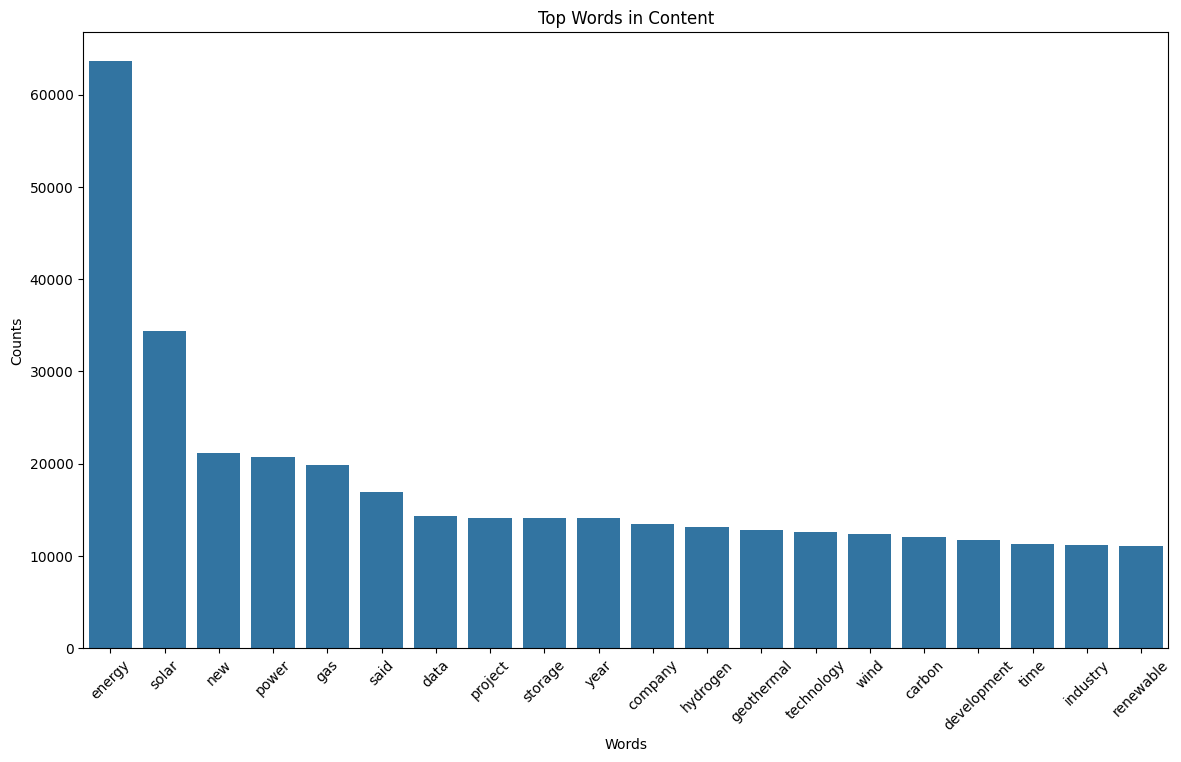

In [8]:
def plot_top_words(data, n_top_words=20):
    # Vectorizer to count word frequencies, ignoring common English stopwords
    vectorizer = CountVectorizer(stop_words="english")
    word_count_matrix = vectorizer.fit_transform(data)

    # Summing word counts and sorting
    sum_words = word_count_matrix.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Extract top N words
    top_words = words_freq[:n_top_words]
    words, counts = zip(*top_words)

    # Plotting
    plt.figure(figsize=(14, 8))
    sns.barplot(x=list(words), y=list(counts))
    plt.xticks(rotation=45)
    plt.xlabel("Words")
    plt.ylabel("Counts")
    plt.title("Top Words in Content")
    plt.show()


# Plot top words in content
plot_top_words(data["content"], n_top_words=20)

To get a feel for what's being talked about in all these cleantech articles, we counted up all the words and made a list of the ones that show up the most. We skipped over small words like "the" and "is" that don't tell us much about the topic.

Here's how we did it:

1. We used a tool that counts words to go through all the articles.
2. Then we added up all the times each word appears.
3. We sorted them so the most common words are at the top of the list.
4. We picked the top 20 words to look at.

### <a id='toc4_3_5_'></a>[Highlighting Key Terms with TF-IDF](#toc0_)

We have another neat way to find out which words might be really important in our articles. It's called TF-IDF, which stands for "Term Frequency-Inverse Document Frequency". It finds words that are common in a few articles but not in all of them. This usually means these words are key ideas in those articles.

Here's how we go about it:

1. We use the TF-IDF Vectorizer to turn our articles into a math problem that the computer can understand.
2. We then add up the scores for each word across all articles.
3. After that, we make a list of the top words based on their scores.
4. We draw a bar chart to show these words, with the highest scoring words at the top.

These top-scoring words are often the ones that tell us the most about what's unique in our articles. We expect to see some words that are very much about clean technology topics.

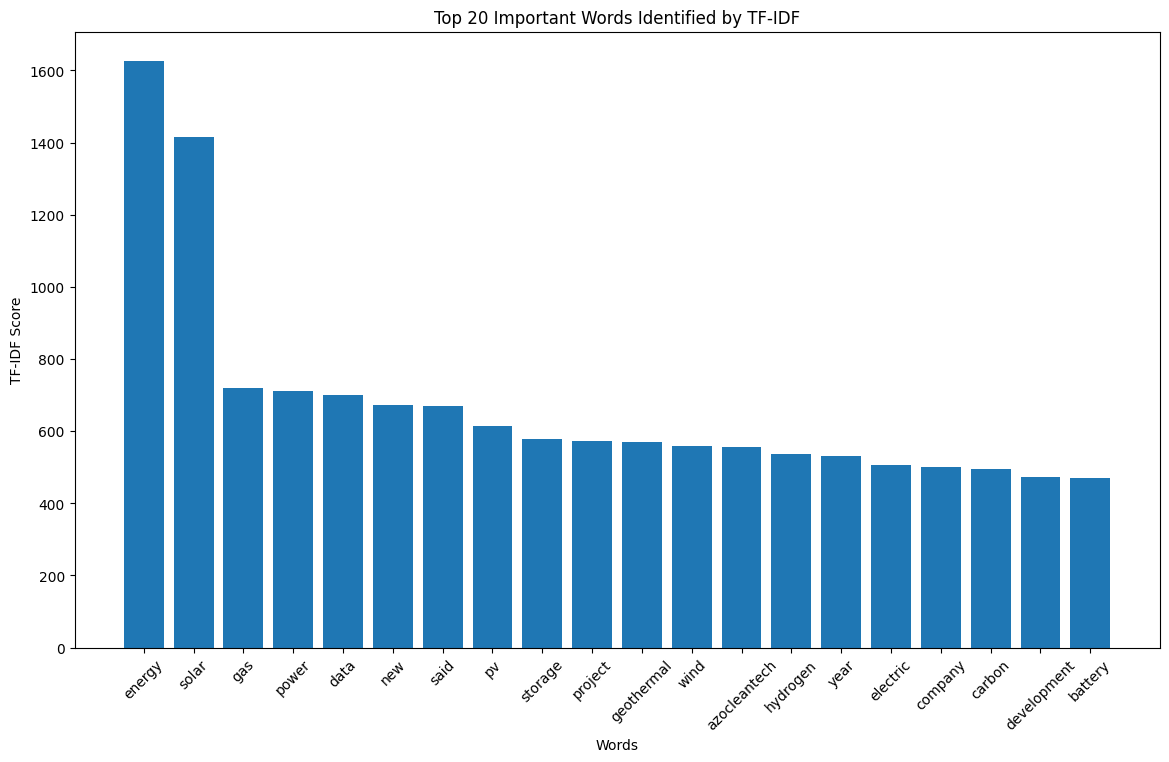

In [9]:
# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    stop_words="english", max_features=100
)  # Considering top 100 features for simplicity

# Fit and transform the content to a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(data["content"])

# Sum the TF-IDF scores for each word across all documents
sum_tfidf = tfidf_matrix.sum(axis=0)

# Create a DataFrame for word scores
words = vectorizer.get_feature_names_out()
scores = sum_tfidf.A1  # Convert to a numpy array
tfidf_scores = pd.DataFrame(
    list(zip(words, scores)), columns=["word", "score"]
).sort_values(by="score", ascending=False)

# Plot the top 20 words
plt.figure(figsize=(14, 8))
plt.bar(tfidf_scores["word"][:20], tfidf_scores["score"][:20])
plt.xticks(rotation=45)
plt.title("Top 20 Important Words Identified by TF-IDF")
plt.xlabel("Words")
plt.ylabel("TF-IDF Score")
plt.show()

### <a id='toc4_3_6_'></a>[Important Words by TF-IDF](#toc0_)

This chart still has "energy" and "solar" at the top, but we also see important terms like "azocleantech," "geothermal," and "hydrogen" that might point to specialized topics within the field.

### <a id='toc4_3_7_'></a>[Key Observations](#toc0_)
- **Overlap**: Both charts have "energy" and "solar" as significant words, reinforcing their centrality to cleantech.
- **Unique TF-IDF Terms**: Words like "azocleantech" and "geothermal" might not be the most common, but they're significant within certain articles. This could mean there's substantial discussion about these topics in some domains.
- **Frequency vs. Relevance**: The common word chart reflects frequency and might include more general terms. The TF-IDF chart emphasizes relevance, bringing domain-specific language and specialized topics to light.

When comparing the two charts, it becomes clear that while the frequency gives a sense of overall enthusiasm, the TF-IDF provides insight into the individual conversations within that enthusiasm. This is valuable in determining not only what is being talked about the most, but also what is unique in the discourse.

### <a id='toc4_3_8_'></a>[Analyzing Article Trends Over Time](#toc0_)

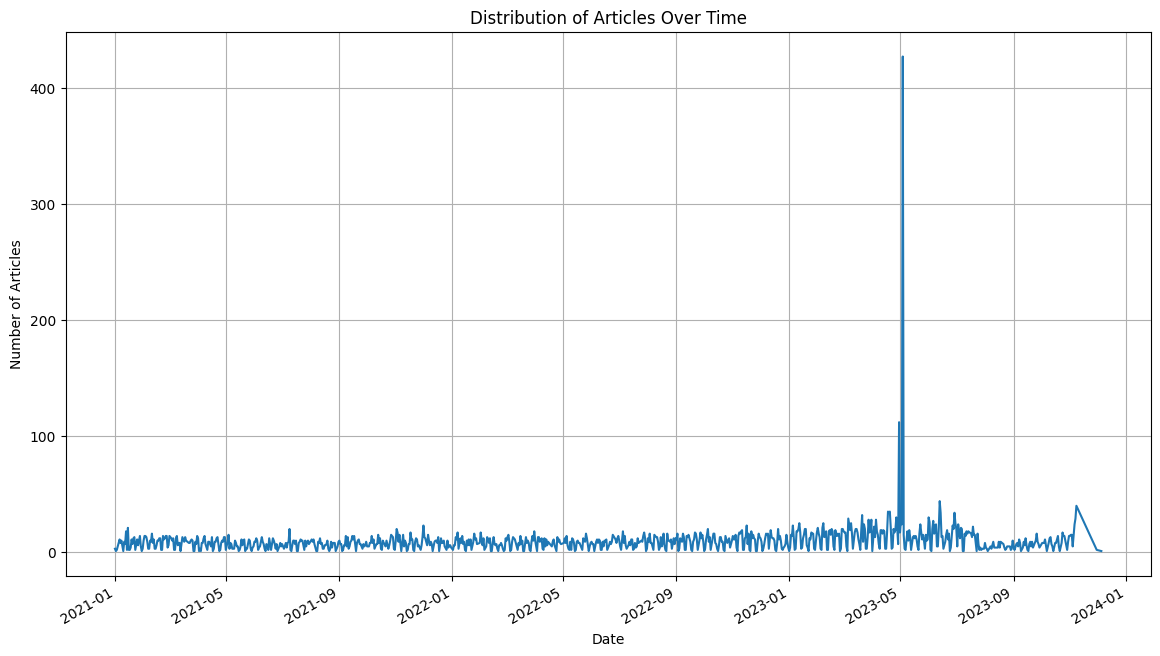

In [10]:
# Plot the number of articles by date
plt.figure(figsize=(14, 8))
articles_by_date.plot()
plt.title("Distribution of Articles Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()

The line graph we've created gives us a visual story of how many articles were published on each date across our dataset. It looks like there's a pretty steady stream of articles with some spikes here and there. These spikes might tell us about special events or hot topics that got a lot of attention on those days.

For example, you can see a particularly tall spike at one point; something big must have happened then!

### <a id='toc4_3_9_'></a>[Monthly Publication Trends](#toc0_)

/var/folders/1b/fjtybkm10b52njc1ykplk_z40000gn/T/ipykernel_34245/1223016828.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_articles = data.set_index('date').resample('M').size()


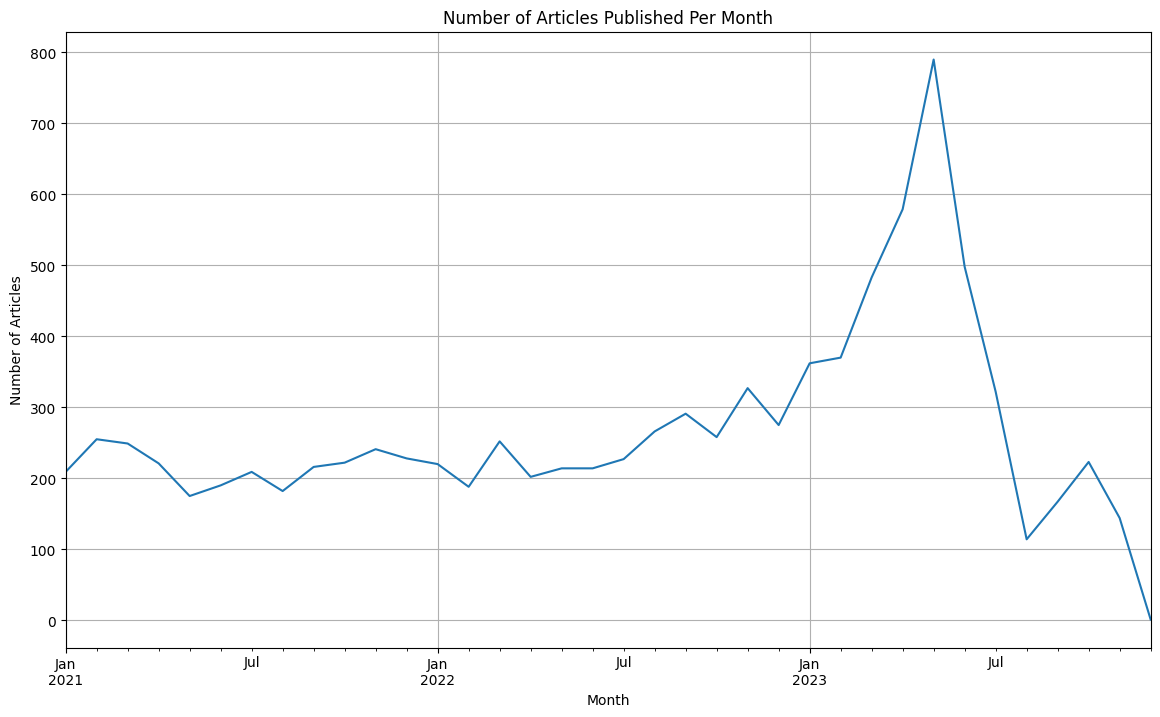

In [11]:
# Resampling the data monthly and counting articles
monthly_articles = data.set_index("date").resample("M").size()

# Plotting the number of articles per month
plt.figure(figsize=(14, 8))
monthly_articles.plot()
plt.title("Number of Articles Published Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()

Our line chart takes us on a journey through time and shows how many articles were published each month. We're looking at how much has been written about clean technology.

Here's what stands out:

- **Steady as She Goes**: By and large, the number of articles each month is pretty consistent.
- **High Speed in Summer**: It could have been a big conference or a major breakthrough in clean technology.

### <a id='toc4_4_10_'></a>[Analysis of Publication Dynamics by Domain](#toc0_)

This section provides insights into the publication patterns of various domains in our dataset, captured through two primary visualizations.

In [12]:
# Analyze the number of publications per domain and the timespan of publications
domain_analysis = (
    data.groupby("domain")
    .agg(
        total_articles=("domain", "size"),
        first_published=("date", "min"),
        last_published=("date", "max"),
    )
    .sort_values(by="total_articles", ascending=False)
)

domain_analysis

,total_articles,first_published,last_published
domain,,,
cleantechnica,1861,2021-01-01,2023-06-15
azocleantech,1627,2021-01-04,2023-05-04
pv-magazine,1205,2021-01-01,2023-12-05
energyvoice,1016,2021-01-05,2023-06-29
solarindustrymag,673,2021-01-06,2023-11-08
naturalgasintel,658,2021-01-04,2023-04-19
thinkgeoenergy,645,2021-01-13,2023-11-08
rechargenews,556,2021-01-08,2023-11-08
solarpowerworldonline,505,2021-01-19,2023-11-08


#### <a id='toc4_4_10_1_'></a>[First and Last Publication Dates by Domain](#toc0_)

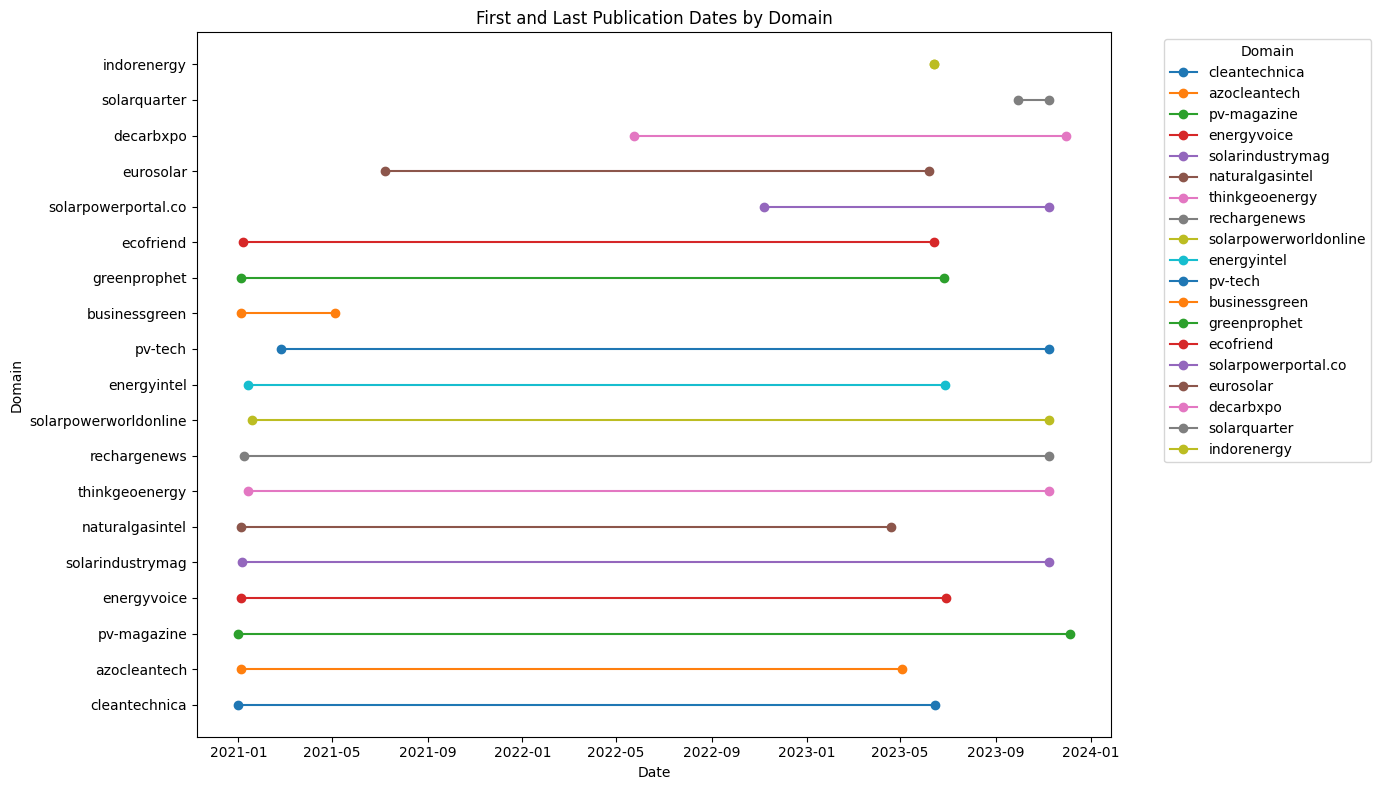

In [13]:
# Plotting first and last publication dates for each domain using a line plot for clarity
fig, ax = plt.subplots(figsize=(14, 8))

# Loop through each domain to plot lines between first and last publication dates
for i, (idx, row) in enumerate(domain_analysis.iterrows()):
    ax.plot(
        [row["first_published"], row["last_published"]], [i, i], marker="o", label=idx
    )

# Set titles and labels
ax.set_title("First and Last Publication Dates by Domain")
ax.set_xlabel("Date")
ax.set_ylabel("Domain")
ax.set_yticks(range(len(domain_analysis)))
ax.set_yticklabels(domain_analysis.index)
ax.legend(title="Domain", bbox_to_anchor=(1.05, 1), loc="upper left")

# Improve layout to accommodate legend
plt.tight_layout()
plt.show()

The plot illustrates the first and last publication dates for each domain. This timeline highlights the active period of content publication across different sources:

- **Longevity and Consistency**: Domains like 'cleantechnica' and 'azocleantech' show a sustained period of activity throughout the dataset timeframe, indicating a consistent output of content.
- **New Entrants**: Domains such as 'solarquarter' and 'indorenergy' have a very recent and brief presence, suggesting they are newer platforms or have only recently been included in the dataset.
- **Inactive Periods**: Some domains like 'businessgreen' show activity that ceases early in the timeframe, which could indicate a shift in publication focus or cessation of operations.

This visualization helps us understand the historical activity and current relevance of each domain in the context of our dataset.

#### <a id='toc4_4_10_2_'></a>[Distribution of Articles Over Time by Domain](#toc0_)

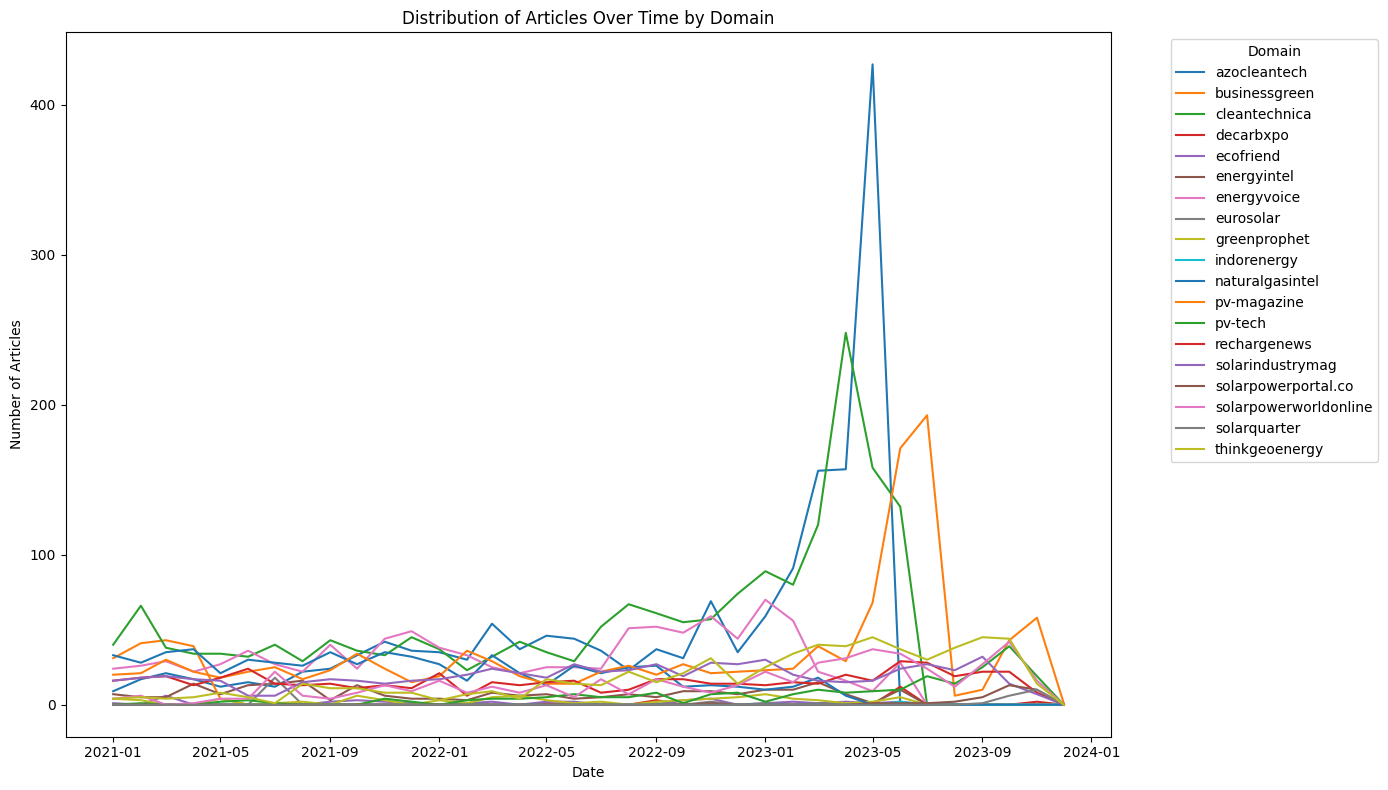

In [14]:
# Aggregating data by month and domain
data["month"] = data["date"].dt.to_period("M")
monthly_data = data.groupby(["month", "domain"]).size().unstack(fill_value=0)

# Plotting the distribution of articles over time for each domain
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each domain as a line
for column in monthly_data.columns:
    ax.plot(monthly_data.index.to_timestamp(), monthly_data[column], label=column)

# Set titles and labels
ax.set_title("Distribution of Articles Over Time by Domain")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Articles")
ax.legend(title="Domain", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()

The line plot displays the monthly distribution of articles for each domain, revealing how publication volumes have changed over time:

- **Trends and Peaks**: Several domains, including 'cleantechnica' and 'pv-magazine', exhibit significant peaks, which could correlate with industry events or news cycles.
- **Growth Trajectories**: The plot shows varying growth trajectories, with some domains rapidly increasing their output over time, while others remain steady or decline.
- **Domain Activity Comparison**: This visualization enables a direct comparison of publication activity across domains, highlighting leaders in content generation and those with more sporadic contributions.

Together, these plots provide a comprehensive overview of the publication landscape within our dataset, offering valuable insights into the dynamics of content generation across different domains.

#### <a id='toc4_3_9_1_'></a>[Checking Out Who Publishes What](#toc0_)

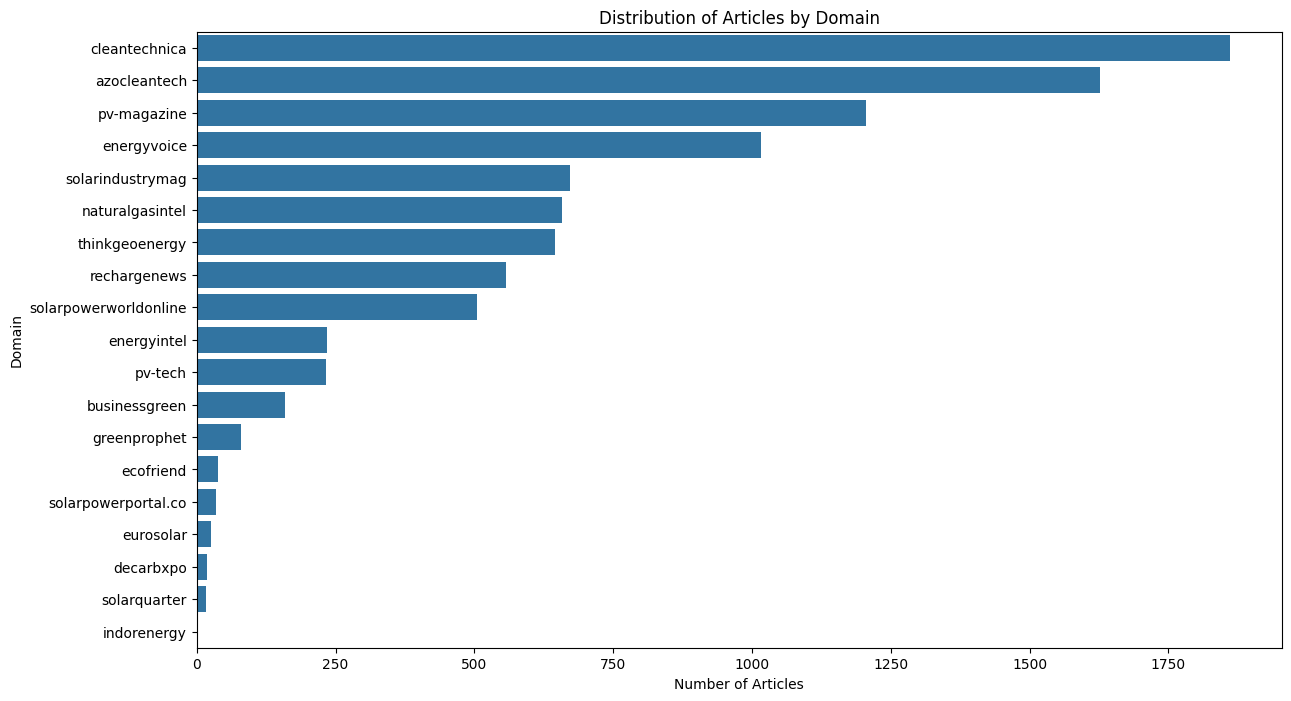

In [15]:
# Plot the number of articles by domain
plt.figure(figsize=(14, 8))
sns.barplot(x=articles_by_domain.values, y=articles_by_domain.index)
plt.title("Distribution of Articles by Domain")
plt.xlabel("Number of Articles")
plt.ylabel("Domain")
plt.show()

This colorful bar chart is like a leaderboard showing which websites talk the most about clean technology. It's clear that some places have a lot to say! For instance, 'cleantechnica' is way ahead of everyone else, which makes it seem like they're really into sharing news and stories about clean tech.

#### <a id='toc4_3_9_2_'></a>[Feeling the Pulse of Sentiment](#toc0_)

##### Average Sentiment Polarity Over Time

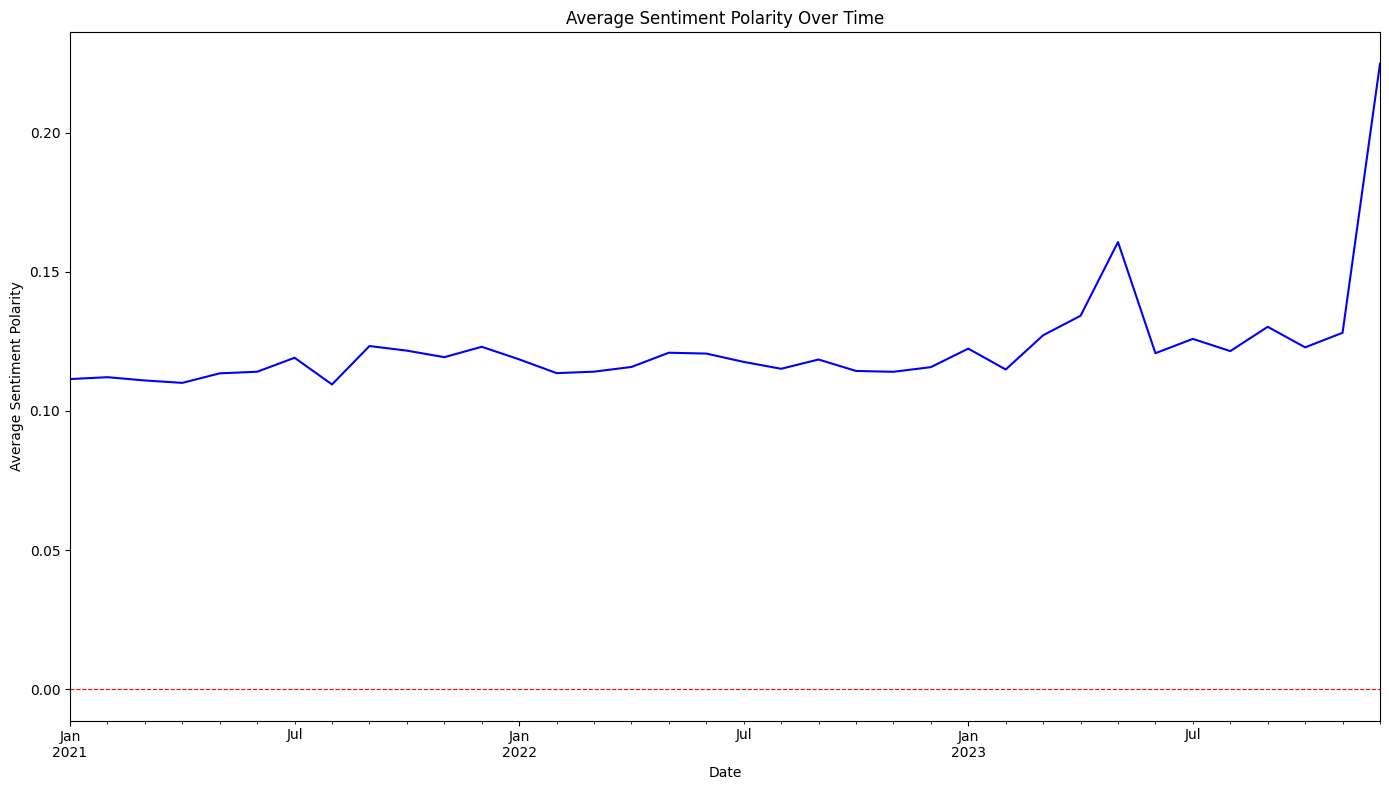

In [16]:
# calculate the sentiment polarity for each article
data["sentiment_polarity"] = data["content"].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

# group the data by month and calculate the average sentiment polarity
monthly_sentiment = data.groupby("month")["sentiment_polarity"].mean()

# plot the average sentiment polarity over time
fig, ax = plt.subplots(figsize=(14, 8))
monthly_sentiment.plot(ax=ax, color="blue")

ax.set_title("Average Sentiment Polarity Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Average Sentiment Polarity")
ax.axhline(0, color="red", linewidth=0.8, linestyle="--")

plt.tight_layout()
plt.show()

The first plot shows the average sentiment polarity over time. Key observations include:

- **General Trend**: The sentiment has generally hovered slightly above neutral (0) throughout the observed period, indicating a mildly positive tone in the overall content.
- **Notable Peaks**: There is a significant spike in sentiment polarity around mid-2023, which may correspond to particular events or impactful news in the dataset's context.

This time-based sentiment analysis helps in identifying periods of significant positivity or negativity, which can be correlated with external events or specific topics gaining attention.

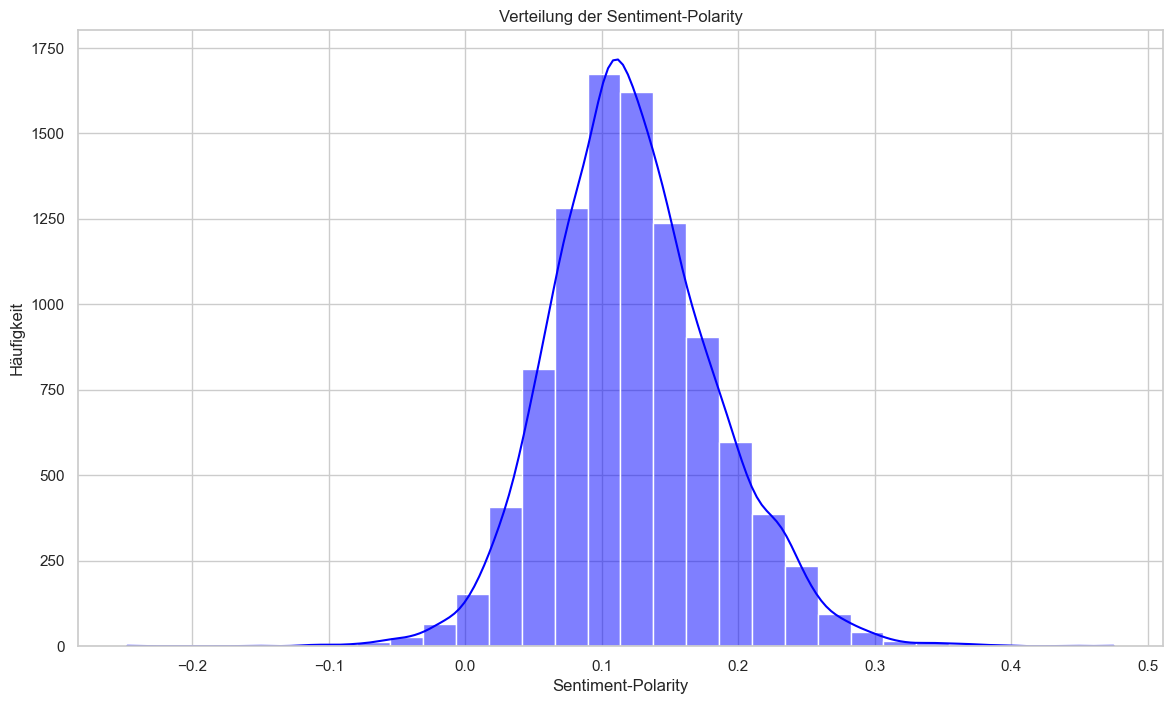

In [17]:
# Set plot style for better visualization
sns.set(style="whitegrid")

# Plotting the distribution of sentiment polarity with a histogram and a density plot overlay
fig, ax = plt.subplots(figsize=(14, 8))
sns.histplot(data["sentiment_polarity"], bins=30, kde=True, color="blue", ax=ax)

# Set titles and labels
ax.set_title("Verteilung der Sentiment-Polarity")
ax.set_xlabel("Sentiment-Polarity")
ax.set_ylabel("Häufigkeit")

# Show the plot
plt.show()

The second plot provides a histogram overlaid with a kernel density estimation, showing the distribution of sentiment polarity scores across all articles:

- **Central Tendency**: The distribution is centered slightly above zero, confirming the slight positive bias in sentiment.
- **Spread and Variability**: Most sentiment scores are close to neutral, with fewer articles exhibiting strong positive or negative sentiments.

This distribution offers insights into the general emotional tone of the content and highlights the prevalence of neutral over strongly polarized sentiments.

In [18]:
# find the most negative and positive report
most_negative_report = data.loc[data["sentiment_polarity"].idxmin()]
most_positive_report = data.loc[data["sentiment_polarity"].idxmax()]

# print the most negative and positive report
most_negative_info = f"Most Negative Report: {most_negative_report['title'], most_negative_report['content']} (Polarity: {most_negative_report['sentiment_polarity']})"
most_positive_info = f"Most Positive Report: {most_positive_report['title'], most_positive_report['content']} (Polarity: {most_positive_report['sentiment_polarity']})"

most_negative_info, most_positive_info

("Most Negative Report: ('Niger-Benin pipeline ceremony due May 20 - News for the Energy Sector', 'Benin plans to officially begin work on a crude oil export pipeline on May 20. , Benin President Patrice Talon will participate in the official launch of construction on May 20, the Ministry of Water and Mines announced. A ceremony will be held on the site of the S m Kpodji station. , The Niger Benin pipeline will run for 1,980 km, of which 685 km will be in Benin. It will begin at Agadem, in Niger, and run to Port Seme. , According to the ministry, there will be two pumping stations, in Gogounou and Tchatchou, and a terminal station in S m Kpodji. The plan also involves a deepwater export terminal, with a single point mooring system. , Construction will take two years, the ministry said, and will require 3,000 workers. The pipeline will create 300 permanent jobs. , Benin and Niger signed a bilateral agreement on the 90,000 barrel per day pipeline in January 2019. , Benin saw off competit

##### <a id='toc4_4_10_4_2_'></a>[Average Sentiment Polarity by Domain](#toc0_)

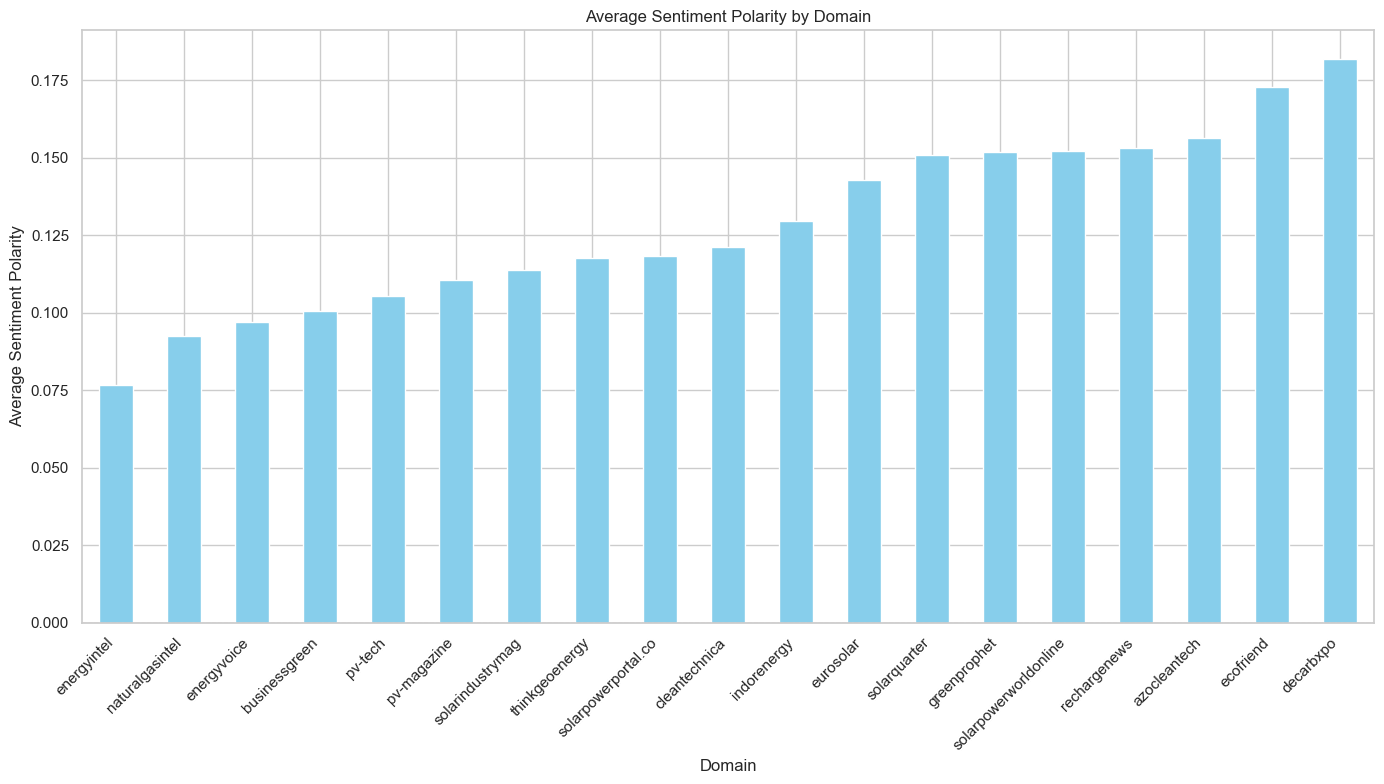

In [19]:
# calculate the average sentiment polarity for each domain
average_sentiment_by_domain = (
    data.groupby("domain")["sentiment_polarity"].mean().sort_values()
)

fig, ax = plt.subplots(figsize=(14, 8))
average_sentiment_by_domain.plot(kind="bar", color="skyblue", ax=ax)
ax.set_title("Average Sentiment Polarity by Domain")
ax.set_xlabel("Domain")
ax.set_ylabel("Average Sentiment Polarity")
ax.axhline(0, color="red", linewidth=0.8, linestyle="--")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The final plot compares the average sentiment polarity across different domains:

- **Domain Variability**: Different domains show varying average sentiment scores, suggesting domain-specific trends in how subjects are discussed or presented.
- **High and Low Sentiment Domains**: Some domains consistently show higher positivity in their content, while others are closer to neutral, indicating potential differences in editorial tone or subject matter focus.

This comparative analysis across domains is crucial for understanding how different sources contribute to the overall sentiment landscape and can help in tailoring content strategies or further analyses for specific domains.

#### <a id='toc4_3_9_3_'></a>[Wordiness Across Domains](#toc0_)

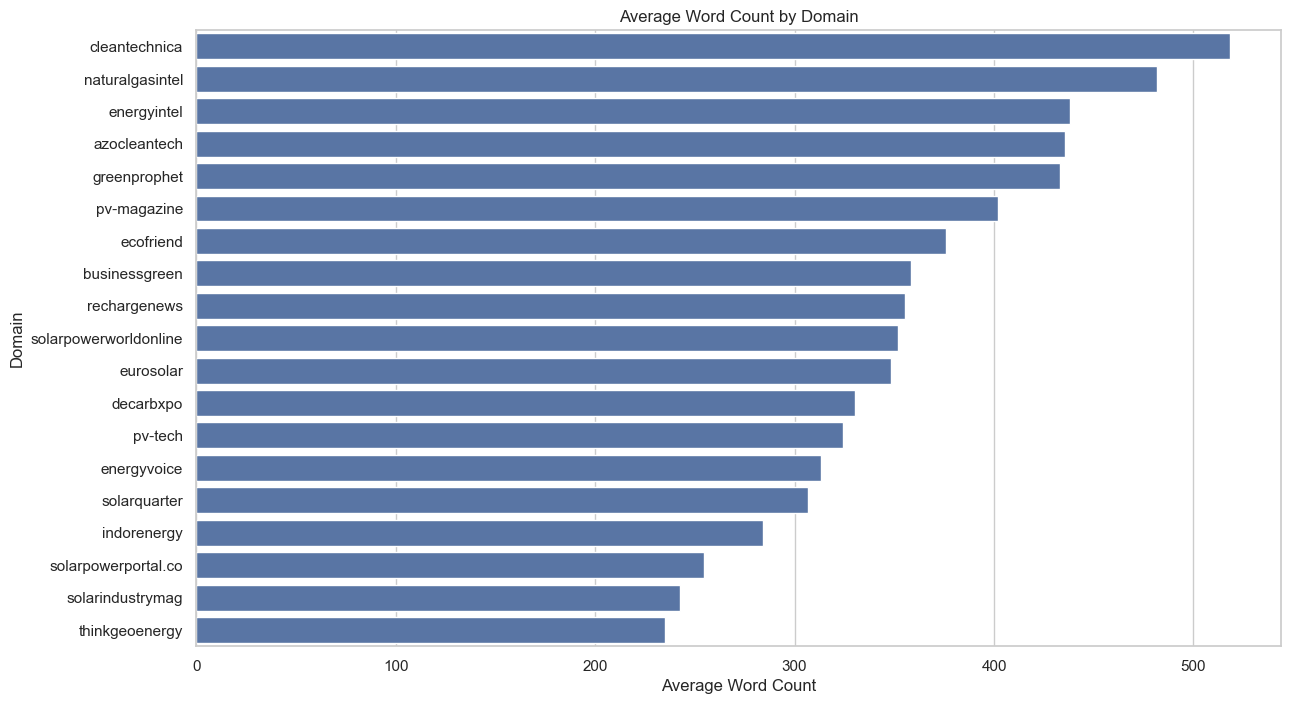

In [20]:
# unique words in each article
data["unique_word_count"] = data["content"].apply(lambda x: len(set(str(x).split())))

# Average word count by domain
avg_word_count_by_domain = (
    data.groupby("domain")["unique_word_count"].mean().sort_values(ascending=False)
)

# Plotting average word count by domain
plt.figure(figsize=(14, 8))
sns.barplot(x=avg_word_count_by_domain.values, y=avg_word_count_by_domain.index)
plt.title("Average Word Count by Domain")
plt.xlabel("Average Word Count")
plt.ylabel("Domain")
plt.show()

This bar chart not only shows who is talking about cleantech, but also how much they are saying. It shows the average length of articles for each area.

Here's what we can take away from it:

- **Long Reads**: Some domains, such as ‘cleantechnica’, offer some pretty lengthy articles.
- **Short and sweet**: At the other end of the scale, there are sites like ‘solarindustry’ where the articles are shorter.

## <a id='toc5_1_'></a>[Analysis of Flesch Reading Ease Scores Across Domains](#toc0_)

The Flesch Reading Ease Score is a tool used to evaluate how easy it is to understand a text based on the length of sentences and the number of syllables per word. Scores can range from -100 (very difficult to read) to 100 (very easy to read). We have applied this measurement to our dataset to assess the readability of articles across different domains.

### <a id='toc5_1_1_'></a>[Overall Distribution of Reading Ease](#toc0_)


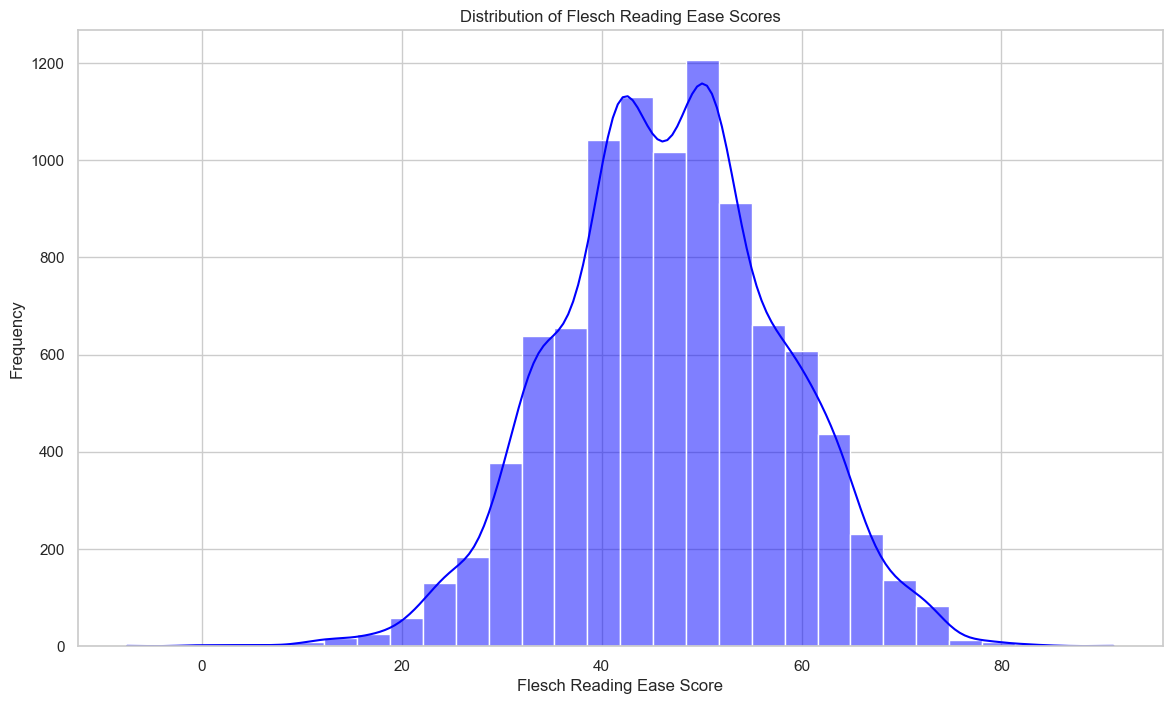

In [24]:
# use textstat to calculate the Flesch Reading Ease Score
from textstat import flesch_reading_ease

# Calculate the Flesch Reading Ease Score for each article
data["reading_ease"] = data["content"].apply(flesch_reading_ease)

# Plot the distribution of Flesch Reading Ease Scores
plt.figure(figsize=(14, 8))
sns.histplot(data["reading_ease"], bins=30, kde=True, color="blue")
plt.title("Distribution of Flesch Reading Ease Scores")
plt.xlabel("Flesch Reading Ease Score")
plt.ylabel("Frequency")
plt.show()

The histogram of Flesch Reading Ease Scores across all articles shows a predominant peak around the score of 50, which indicates a fairly moderate level of readability with some content leaning towards more complex structures. This peak is critical as it suggests that the majority of the content is accessible to a standard audience but may still challenge readers with less advanced reading skills.

### <a id='toc5_1_2_'></a>[Domain-Specific Readability](#toc0_)

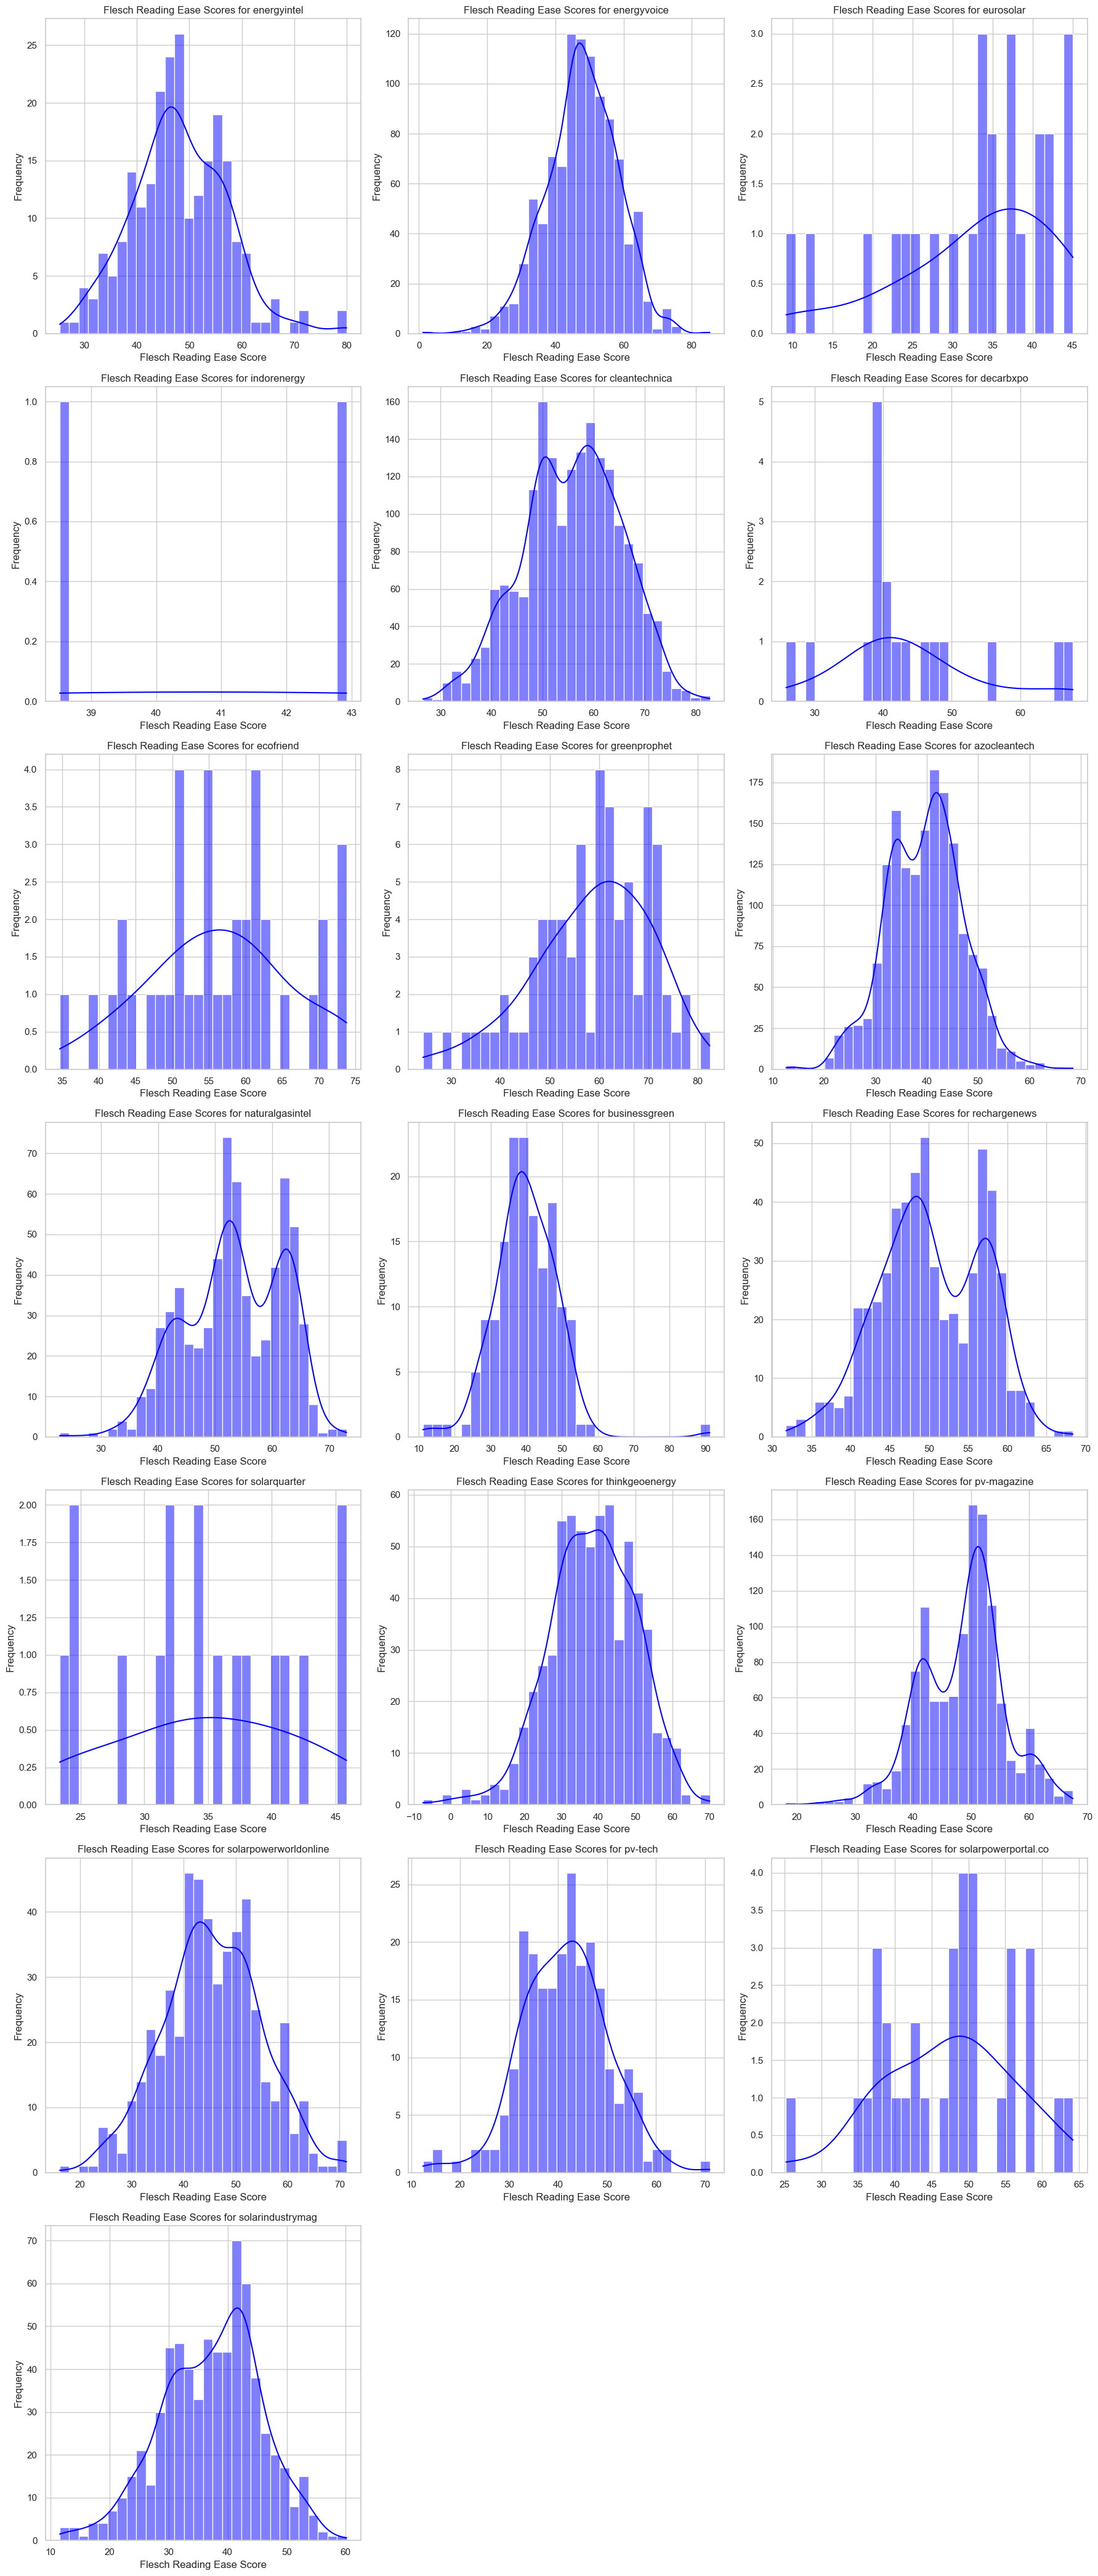

In [25]:
# Liste der einzigartigen Domänen
domains = data["domain"].unique()

# Einstellen der Größe für die Subplots
rows = (len(domains) + 2) // 3  # Berechne, wie viele Zeilen benötigt werden
fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows))  # 6 ist die Höhe jeder Reihe
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot für jede Domäne
for i, domain in enumerate(domains):
    domain_data = data[data["domain"] == domain]
    sns.histplot(
        domain_data["reading_ease"], bins=30, kde=True, color="blue", ax=axes[i]
    )
    axes[i].set_title(f"Flesch Reading Ease Scores for {domain}")
    axes[i].set_xlabel("Flesch Reading Ease Score")
    axes[i].set_ylabel("Frequency")

# Entfernen von leeren Subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Zeige den Plot
plt.tight_layout()
plt.show()

The collection of subplots for each domain reveals significant variability in readability:
- **Domains like 'cleantechnica' and 'energyvoice'** show distributions centered around higher readability scores, suggesting their content is generally easier to comprehend.
- **Conversely, domains such as 'solarquarter' and 'rechargenews'** exhibit distributions with lower ease scores, indicating more complex language that might be targeted towards professional or academic readers.

These insights are essential for content creators and marketers within these domains to understand their audience better and tailor their writing to meet readers' needs.